<a href="https://colab.research.google.com/github/furkancimen/COT5600/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy import linalg as LA

np.set_printoptions(precision=3, suppress=True)

def get_fourier_matrix (N):
  ''' This function creates and returns NxN fourirer matrix for a given N'''

  fourier_matrix = np.zeros([N,N], dtype=complex)
  for k in range(N):
    for l in range(N):
      fourier_matrix[k,l] = 1/np.sqrt(N)*np.exp((-2j*np.pi/N)*k*l)
  return fourier_matrix

N=4
print(f'Fourier MAtrix of size {N}')
F = get_fourier_matrix(N)
print(F)
print("Check whether it's unitary? Multiplication with its complex conjuagte should be Identity matrix")
print(np.matmul(F, np.conj(np.transpose(F))))
print("Check whether its polynomial power 4 is Identity matrix")
print(LA.matrix_power(F, 4))
print("Check its eigen values. For size 4 we expect 2 '+1', 1 '-1' and 1 '-j'")
eig, _ = LA.eig(F)
print(eig)

Fourier MAtrix of size 4
[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. -0.5j -0.5-0.j  -0. +0.5j]
 [ 0.5+0.j  -0.5-0.j   0.5+0.j  -0.5-0.j ]
 [ 0.5+0.j  -0. +0.5j -0.5-0.j   0. -0.5j]]
Check whether it's unitary? Multiplication with its complex conjuagte should be Identity matrix
[[ 1.+0.j -0.+0.j  0.+0.j  0.+0.j]
 [-0.-0.j  1.+0.j -0.+0.j  0.+0.j]
 [ 0.-0.j -0.-0.j  1.+0.j -0.+0.j]
 [ 0.-0.j  0.-0.j -0.-0.j  1.+0.j]]
Check whether its polynomial power 4 is Identity matrix
[[ 1.-0.j  0.-0.j -0.-0.j  0.-0.j]
 [ 0.-0.j  1.+0.j -0.-0.j  0.-0.j]
 [-0.-0.j -0.-0.j  1.+0.j -0.-0.j]
 [ 0.-0.j  0.-0.j -0.-0.j  1.+0.j]]
Check its eigen values. For size 4 we expect 2 '+1', 1 '-1' and 1 '-j'
[ 1.-0.j -1.-0.j  0.-1.j  1.+0.j]


In [0]:
import numpy as np
from numpy import linalg as LA

np.set_printoptions(precision=3, suppress=True)

def get_cyclic_shift_matrix(N):
  '''This function creates and returns NxN cyclic shift matrix for a given N'''

  cyclic_shift_matrix = np.zeros([N,N])
  for k in range(N):
    cyclic_shift_matrix[k, (k+1)%N] = 1

  return cyclic_shift_matrix


print(f'Cyclic shift matrix of size N={N}')
P = get_cyclic_shift_matrix(N)
print(P)
print("Check whether it's unitary? Multiplication with its complex conjuagte should be Identity matrix")
print(np.matmul(P, np.transpose(P)))
print(f"Check whether its polynomial power N={N} is Identity matrix")
print(LA.matrix_power(P, N))
print("Check its eigen values. For size 4 we expect '+1', '-1', '+j' and '-j'")
eig, _ = LA.eig(P)
print(eig)
print("Check the cyclic shift matrix is diagonalized by the Fourier matrix")
F_dagger = np.conj(np.transpose(F))
print(np.matmul(np.matmul(F_dagger, P), F))

Cyclic shift matrix of size N=4
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
Check whether it's unitary? Multiplication with its complex conjuagte should be Identity matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Check whether its polynomial power N=4 is Identity matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Check its eigen values. For size 4 we expect '+1', '-1', '+j' and '-j'
[-1.+0.j  0.+1.j  0.-1.j  1.+0.j]
Check the cyclic shift matrix is diagonalized by the Fourier matrix
[[ 1.+0.j -0.-0.j  0.-0.j  0.-0.j]
 [-0.+0.j  0.-1.j -0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.-0.j  0.+1.j]]


The expected result is 001 => 1 divided by 2^3=8 which is theta=1/8
T gate ads pi/4 phase so theta for T gate is pi/4


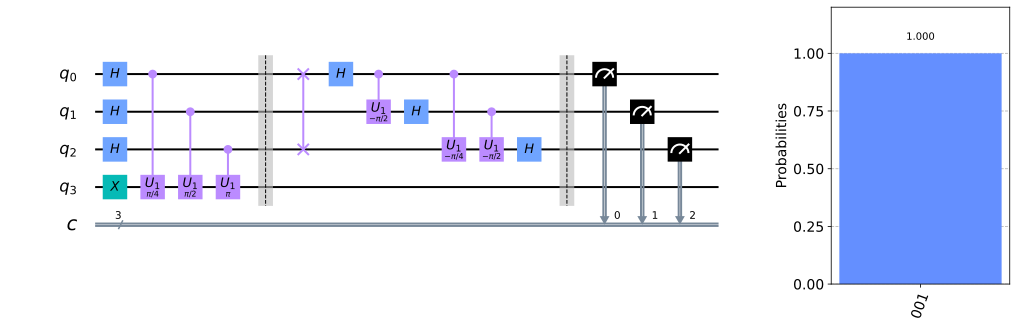

In [22]:
import numpy as np
from numpy import pi
!pip install -q folium==0.2.1
!pip install -q qiskit==0.16
#!pip install -q pygments
#!pip install -q qiskit-terra[visualization]
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' # Makes the images look nice


def inverse_qft(qc, n_qb):
  '''This functions gets a quantum circuit and number of qubits and applies 
     inverse quantum fourier transform to the first n qubits of the given circuit'''

  # Let's first apply the swaps
  for qb in range(n_qb//2):
      qc.swap(qb, n_qb-qb-1)
  # now the actual circuit
  for k in range(n_qb):
    for l in range(k):
      lambda_u1 = -2*pi/2**(k-l+1)
      qc.cu1(lambda_u1, l, k)
    qc.h(k)

def create_counting_circuit(qc, n_qb, theta):
  '''This functions gets a quantum circuit, number of qubits and angle of
     gate to be measured and constructs counting circuit'''
  # First apply H-Gates to counting qubits
  for qb in range(n_qb):
    qc.h(qb)

  # Do the controlled-U operations:
  angle = 2*pi*theta
  repetitions = 1
  for counting_qb in range(n_qb):
    qc.cu1(angle*2**counting_qb, counting_qb, n_qb);
    


# number of counting qubits which determines precision
counting_qb = 3
# pec: phase estimation circuit.
# We need one more qubit to represent the eigenstate of our unitary operator
# Also qubits start with index zero
pec = QuantumCircuit(counting_qb+1, counting_qb)

# Prepare our eigenstate |psi> = |1> by applying X gate:
pec.x(counting_qb)
# Let's built our counting circuit with theta=1/8 (T gate)
create_counting_circuit(pec, counting_qb, 1/8)
pec.barrier()

# Let's apply quantum fourier transform now
inverse_qft(pec, counting_qb)
pec.barrier()

# Let's put our measures
for k in range(counting_qb):
    pec.measure(k,k)


# Let's calculate the results
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(pec, backend=backend, shots=shots).result()
answer = results.get_counts()


# Let's plot our circuit and result
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]})
fig.tight_layout()
pec.draw('mpl', ax=axs[0])
plot_histogram(answer, ax=axs[1])

print("The expected result is 001 => 1 divided by 2^3=8 which is theta=1/8")
print("T gate ads pi/4 phase so theta for T gate is pi/4")
